# ITT 2023 LNLS: Compresed Sensing (CS) Challenge
## CS applied to FTIR at LNLS IMBUIA Beamline 

In [2]:
import numpy 
import pandas 
import matplotlib.pyplot as plt
from scipy.optimize import minimize as scipy_minimize
import random
from scipy.optimize import linprog

# Read IMBUIA data

### Air interferogram and Spectrum computed by FTIR software

In [3]:
# Escrever um string com o caminho para o dado na pasta do google drive
path = 'data/'

# Name .csv file
name_espectrum_air = 'ar_ATR_spectrum.csv'
name_interferogram_air = 'ar_atr_interf.csv'

data_air_spectrum = pandas.read_csv(path+name_espectrum_air, header=None)
data_air_spectrum = numpy.asarray(data_air_spectrum)

data_air_interf = pandas.read_csv(path+name_interferogram_air, header=None)
data_air_interf = numpy.asarray(data_air_interf)

transmission_air = numpy.exp(-data_air_spectrum[:,1])

# All the data is written as follows:
#
#
# n_points: number of acquired points
# interferogram.shape = (n_points_interf, 4)
# interferogram: column 0 - x-direction - Optical path [cm]
# interferogram: column 1 - y-direction - Voltz [V]
# ---------------------------------------------------
# spectrum.shape = (n_points_spectrum, 2)
# spectrum: column 0 - x-direction - Frequency [1/cm]
# spectrum: column 1 - y-direction - Absorption

### Plot interferogram and spectrum

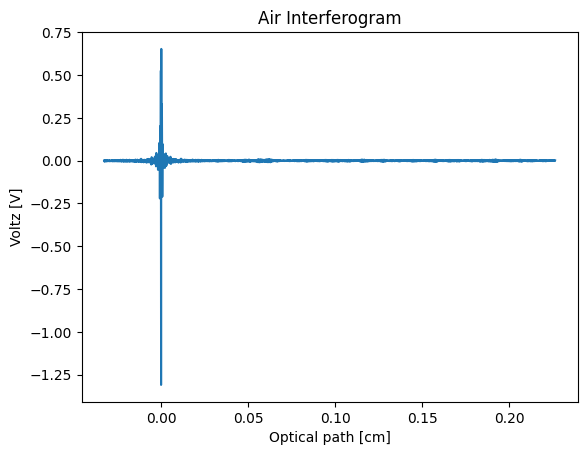

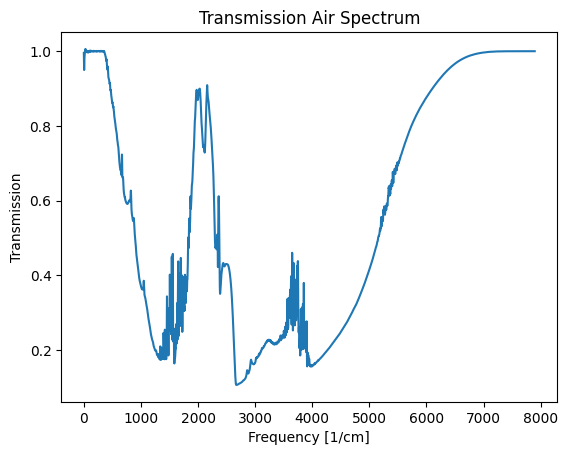

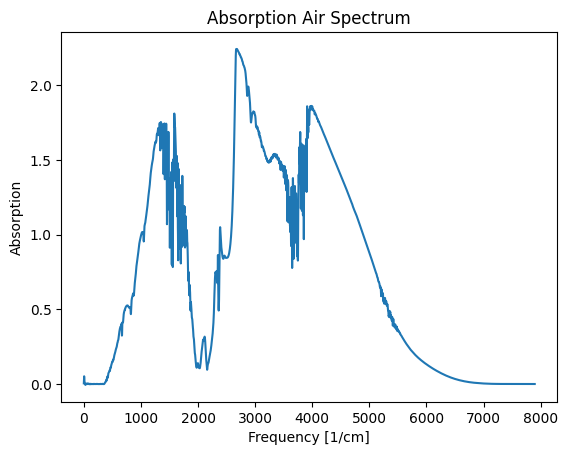

In [4]:
plt.figure(0)
plt.plot(data_air_interf[:,0],data_air_interf[:,1])
plt.xlabel('Optical path [cm]')
plt.ylabel('Voltz [V]')
plt.title('Air Interferogram')

plt.figure(1)
plt.plot(data_air_spectrum[:,0],transmission_air)
plt.xlabel('Frequency [1/cm]')
plt.ylabel('Transmission')
plt.title('Transmission Air Spectrum')

plt.figure(2)
plt.plot(data_air_spectrum[:,0],data_air_spectrum[:,1])
plt.xlabel('Frequency [1/cm]')
plt.ylabel('Absorption')
plt.title('Absorption Air Spectrum')

plt.show()

### Simulated Problem

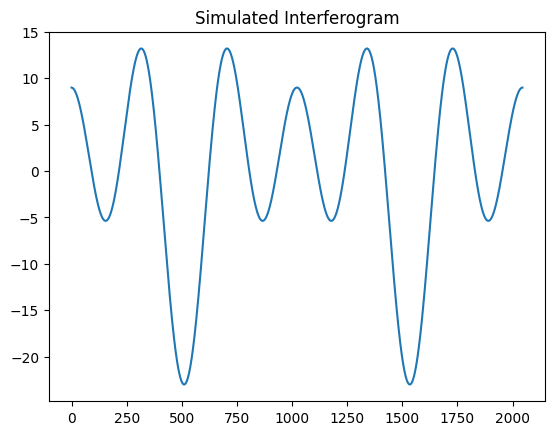

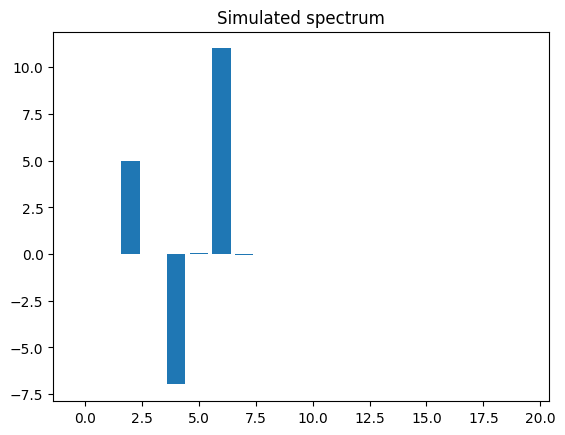

In [5]:
spec_cutoff = 20
specs_x = numpy.arange(spec_cutoff)
percent = 0.85
N       = 1024
M       = int(N*percent)

# Set spectrum :
t        = numpy.linspace(-1,1, 2 * N - 2)
interferogram = 5*numpy.cos(2*numpy.pi*t) - 7*numpy.cos(4*numpy.pi*t) + 11*numpy.cos(6*numpy.pi*t)

# DFT Complex matrix
# D = numpy.fft.fft(numpy.eye(N))
iD = numpy.fft.irfft(numpy.eye(N)).real

# Get interferogram
spectrum = numpy.dot(iD, interferogram).real

# Plot
plt.figure(3)
plt.plot(numpy.fft.fftshift(interferogram))
plt.title('Simulated Interferogram')

plt.figure(4)
plt.bar(x=specs_x, height=spectrum[:spec_cutoff])
plt.title('Simulated spectrum')

plt.show()


## Select M sample datapoints from interferogram

### M data points and M rows of DFT matrix

D shape: (2046, 1024)
iD shape: (1024, 2046)
spectrum shape: (1024,)
interferogram shape: (2046,)
N: 1024
M: 102
A shape: (102, 1024)
B shape: (1024, 102)
interfero shape: (102,)


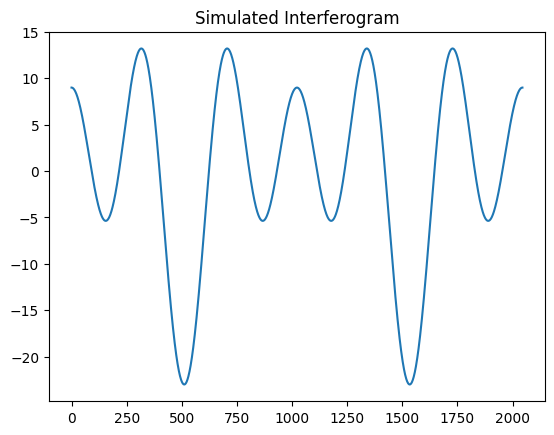

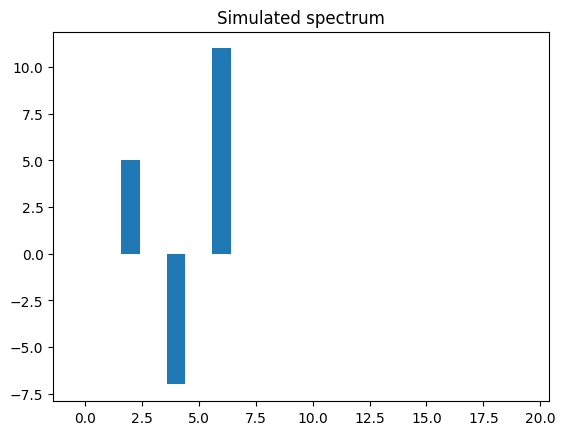

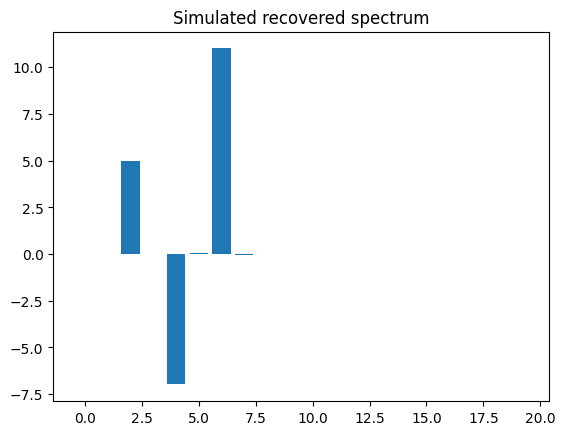

[[ 1.          1.          1.         ...  1.          1.
   1.        ]
 [ 1.          0.99999528  0.99998114 ... -0.99998114 -0.99999528
  -1.        ]
 [ 1.          0.99998114  0.99992455 ...  0.99992455  0.99998114
   1.        ]
 ...
 [ 1.          0.99995756  0.99983025 ... -0.99983025 -0.99995756
  -1.        ]
 [ 1.          0.99998114  0.99992455 ...  0.99992455  0.99998114
   1.        ]
 [ 1.          0.99999528  0.99998114 ... -0.99998114 -0.99999528
  -1.        ]]


In [6]:
percent = 0.10
N       = 1024
M       = int(N*percent)

# Set Simulated Spectrum:
t        = numpy.linspace(-1,1, 2*N - 2)
interferogram = 5*numpy.cos(2*numpy.pi*t) - 7*numpy.cos(4*numpy.pi*t) + 11*numpy.cos(6*numpy.pi*t)

# Real DFT matrix
D  = numpy.fft.rfft(numpy.eye(2*N - 2)).real 
iD = numpy.fft.irfft(numpy.eye(N)).real

spectrum = numpy.zeros(N)
spectrum[[2, 4, 6]] = 5, -7, 11

print('D shape:', D.shape)
print('iD shape:', iD.shape)
print('spectrum shape:', spectrum.shape)
print('interferogram shape:', interferogram.shape)

espectrum_from_interferogram = numpy.dot(iD,interferogram)

# Choose M random rows of D (DFT)
rows_id = numpy.random.choice(2*N - 2,size=M,replace=False)
rows_id.sort()

A = numpy.zeros((M,N))

interfero = numpy.zeros(M)

for i in range(M):
    A[i]          = D[rows_id[i],:] # select M row of DFT matrix D
    interfero[i]  = interferogram[rows_id[i]] # select M datapoints of interferogram

B = A.conjugate().transpose() # select M columns of iDFT matrix iD

print('N:', N)
print('M:', M)

print('A shape:', A.shape)
print('B shape:', B.shape)
print('interfero shape:', interfero.shape)


plt.figure(5)
plt.plot(interferogram)
plt.title('Simulated Interferogram')

plt.figure(6)
plt.bar(x=specs_x, height=spectrum[:spec_cutoff])
plt.title('Simulated spectrum')

plt.figure(7)
plt.bar(x=specs_x,height= espectrum_from_interferogram[:spec_cutoff])
plt.title('Simulated recovered spectrum')

plt.show()

print(D)

### Initial example solving the CS problem by linear programming

In [7]:
def get_s(A, y):
    # Initial example of linear programming function to solve the Compressed sensing problem for FTIR

    x_dim, y_dim = A.shape[1], y.shape[0]

    obj = numpy.ones(2*x_dim)

    lhs_eq = numpy.concatenate((A, -A), axis=1)
    rhs_eq = y

    bnd = [*((0.0, None) for _ in range(2*x_dim))]

    res = linprog(c=obj, A_eq=lhs_eq, b_eq=rhs_eq, bounds=bnd, method="highs")

    return res.x[:x_dim] - res.x[x_dim:]


In [8]:
#solution = get_s(A, spectrum)
solution = get_s(A, interfero)

print(solution.sum())

TypeError: 'NoneType' object is not subscriptable

In [ ]:
solution[:20]

array([ 0.00000000e+00,  0.00000000e+00,  4.96282544e+00,  0.00000000e+00,
       -6.93462129e+00,  7.91478527e-03,  1.09528902e+01,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00])

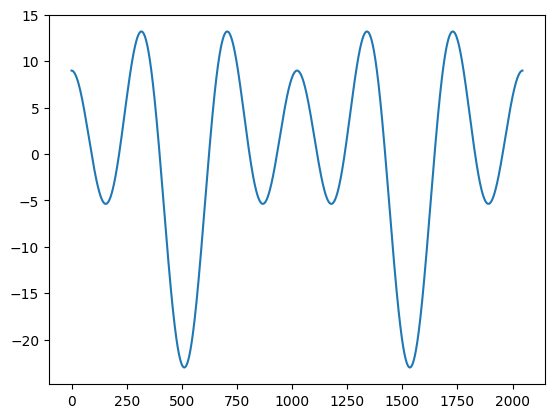

In [ ]:
plt.plot(D @ spectrum)

### Plot and compare solutions

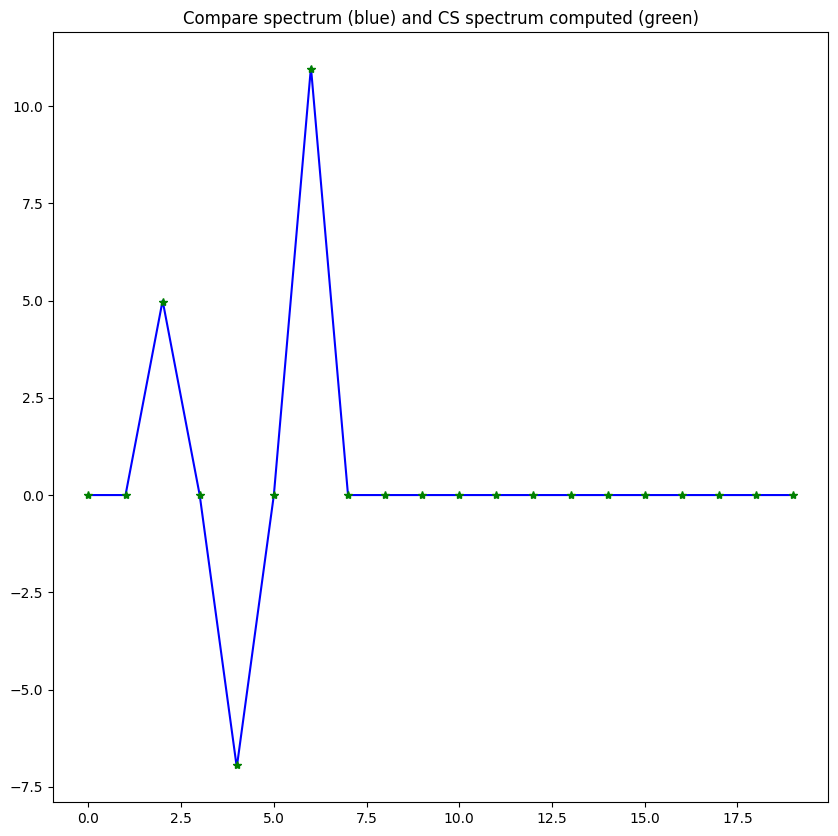

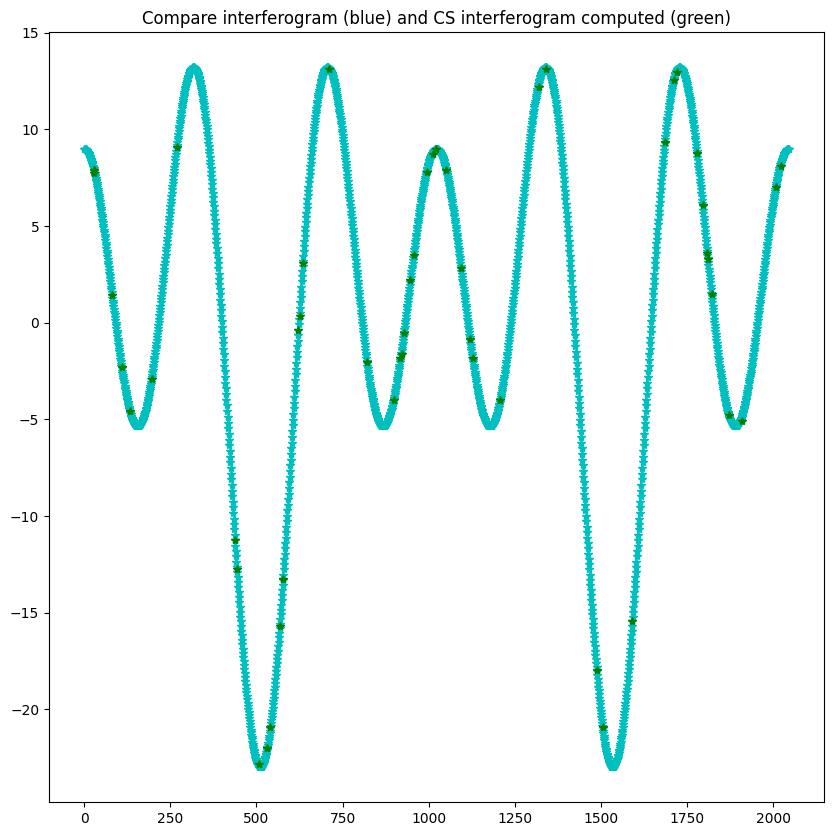

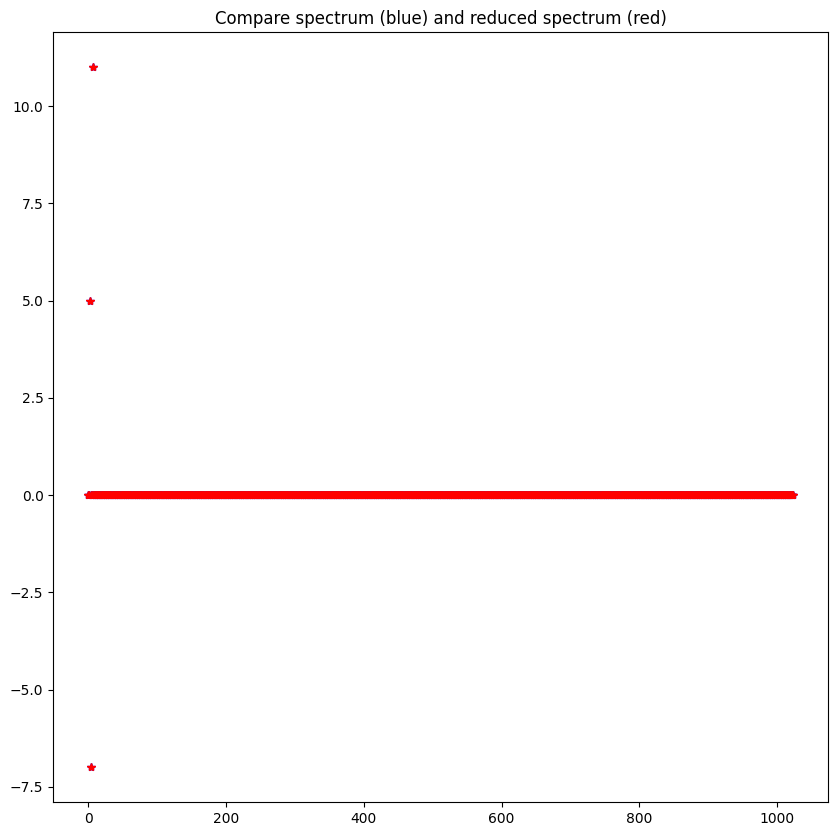

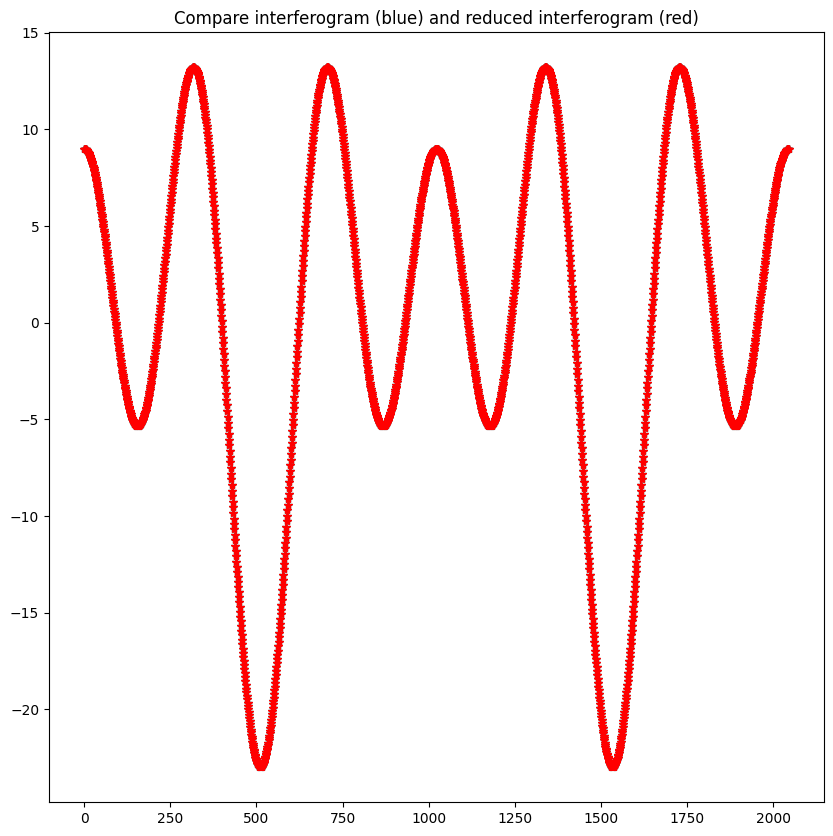

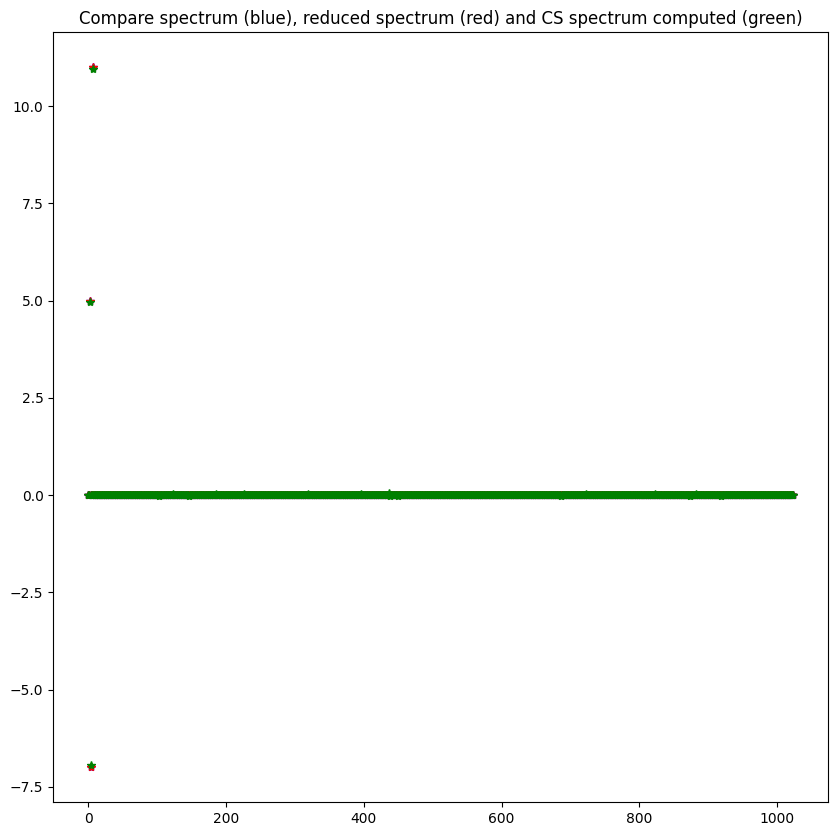

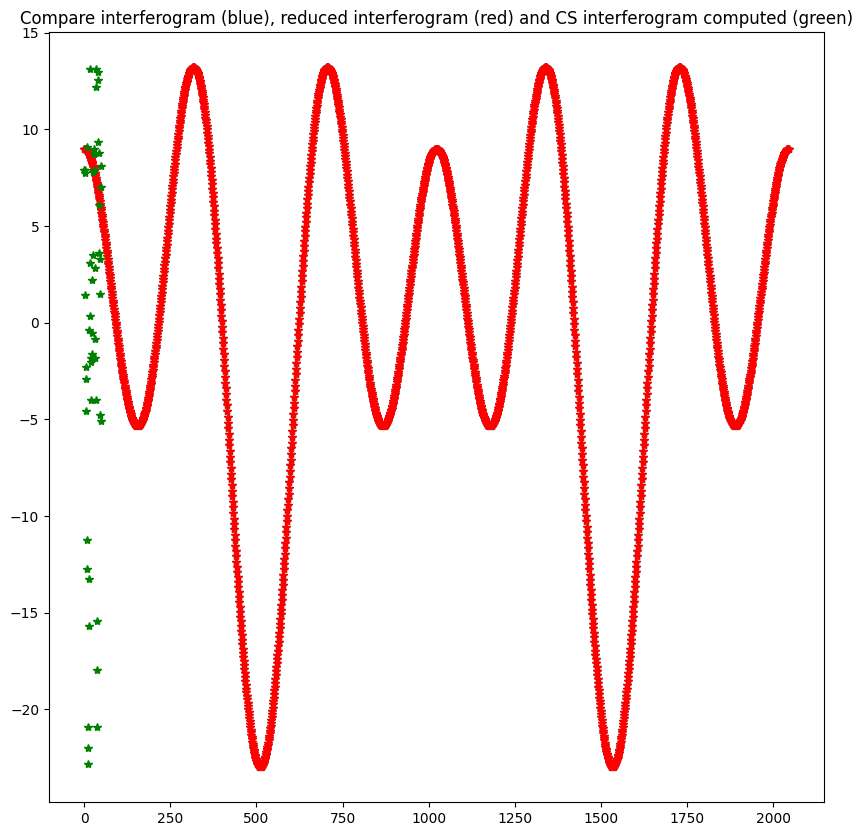

In [ ]:
# Computed simulated solutions
interferogram_computed = numpy.dot(A,solution)
spectrum_computed      = solution

# Provided solutions

interf = interferogram # (numpy.dot(D,spectrum))
spec   = spectrum # (numpy.dot(B,interf))

# Plots
plt.figure(8, figsize=(10,10))
plt.plot(spectrum[:spec_cutoff],'b',spectrum_computed[:spec_cutoff],'g*')
plt.title('Compare spectrum (blue) and CS spectrum computed (green)')

plt.figure(9, figsize=(10,10))
plt.plot(interferogram,'c*')
plt.plot(rows_id, interferogram_computed,'g*')
plt.title('Compare interferogram (blue) and CS interferogram computed (green)')

plt.figure(10, figsize=(10,10))
plt.plot(spectrum,'b*',spec,'r*')
plt.title('Compare spectrum (blue) and reduced spectrum (red)')

plt.figure(11, figsize=(10,10))
plt.plot(interferogram,'c*',interf,'r*')
plt.title('Compare interferogram (blue) and reduced interferogram (red)')

plt.figure(12, figsize=(10,10))
plt.plot(spectrum,'b*',spec,'r*',spectrum_computed,'g*')
plt.title('Compare spectrum (blue), reduced spectrum (red) and CS spectrum computed (green)')

plt.figure(13, figsize=(10,10))
plt.plot(interferogram,'c*',interf,'r*',interferogram_computed,'g*')
plt.title('Compare interferogram (blue), reduced interferogram (red) and CS interferogram computed (green)')

plt.show()



